In [4]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')

# Data loading & prep

In [5]:
# Data loading

df_y = pd.read_excel("credit_data.xlsx", sheet_name="credit_histo")
df_y = df_y[["Date", "Crédits à l'habitat accordés aux particuliers résidents, encours", "Crédits à l'habitat accordés aux particuliers résidents, flux mensuels"]]
df_y.columns = ['Date', 'Encours', 'NP']
df_x = pd.read_excel("credit_data.xlsx", sheet_name="drivers_histo")

df = df_y.merge(df_x, on="Date", how="left")

In [6]:
# Feature engineering

df['OAT_10Y_6MROLLING'] = df['OAT_10Y'].rolling(window=6).mean()
df['Chômage'] = df['Chômage'] * 100
df['Invest_courant_growth'] = df['Ménages - FBCF - Courant'] / df['Ménages - FBCF - Courant'].shift(1)
df['Ratio'] = df['NP'] / df['Ménages - FBCF - Courant']
df['OAT_10Y_6MLAG'] = df['OAT_10Y'].shift(6)
df['OAT_10Y_12MLAG'] = df['OAT_10Y'].shift(12)
df['Euribor_3M_6M_ROLLING'] = df['Euribor_3M'].rolling(window=6).mean()

for i in range(1, 13):
    df[f"Month_{i}"] = df['Date'].dt.month == i

df['Semester_1'] = (df['Date'].dt.month <=6).astype(int)

df['Semester_2'] = (df['Date'].dt.month > 6).astype(int)

df['Feature'] = df['Ménages - FBCF - Courant'] * df['OAT_10Y_6MLAG']


In [7]:
# Data prep

train_range = ("2010-06-01", "2020-12-01")
backtest_range = ("2021-01-01", "2023-02-01")

df_train = df[(df['Date']>=train_range[0]) & (df['Date']<=train_range[1])]
display(df_train.head())

df_backtest = df[(df['Date']>=backtest_range[0]) & (df['Date']<=backtest_range[1])]

Date   Encours           NP            RDB   Chômage            PIB  \
119 2010-06-01  678614.0  9098.107064  105516.753086  8.900000  171638.382716   
120 2010-07-01  685260.0  9736.570718  105813.530864  8.900000  172029.308642   
121 2010-08-01  688609.0  9816.378674  106062.938272  8.900000  172412.160494   
122 2010-09-01  692692.0  9975.994588  106288.530864  8.900000  172807.530864   
123 2010-10-01  695238.0  9816.378674  106467.641975  8.866667  173158.234568   

     Invest_SNF  OAT_10Y  Consommation_ménages  Epargne_ménages  ...  Month_6  \
119  115.343252    3.075          91989.604938     13527.148148  ...     True   
120  115.990481    2.984          92316.222222     13497.308642  ...    False   
121  115.850685    2.678          92542.777778     13520.160494  ...    False   
122  115.678184    2.678          92763.000000     13525.530864  ...    False   
123  116.299702    2.730          92972.197531     13495.444444  ...    False   

     Month_7  Month_8  Month_9  Month_10  Month_11  Month_12  Semester_1  \
119    False    False    False     False     False     False           1   
120     True    False    False     False     False     False           0   
121    False     True    False     False     False     False           0   
122    False    False     True     False     False     False           0   
123    False    False    False      True     False     False           0   

     Semester_2       Feature  
119           0  30802.491000  
120           1  31818.103333  
121           1  31574.113333  
122           1  31059.023333  
123           1  31070.832000  

[5 rows x 39 columns]

# Model

In [8]:
from sklearn.linear_model import LinearRegression

drivers = ['OAT_10Y_6MLAG', 'Semester_1', 'Semester_2'] # + [f"Month_{i}" for i in range(1, 13)] 

lr = LinearRegression().fit(df_train[drivers], df_train['Ratio'])

fit : MAPE of 14.96%


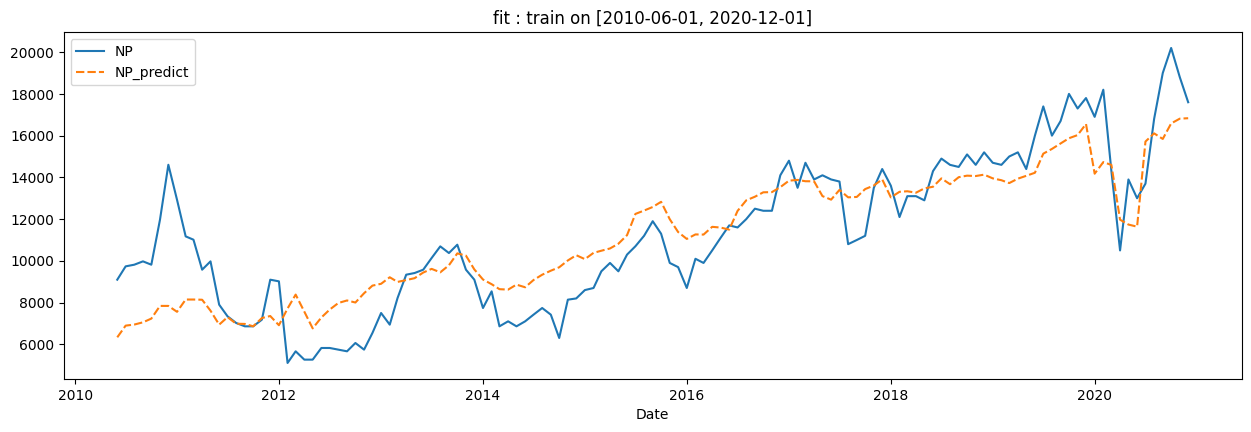

In [9]:
""" fit NP """

predict_new_prods = lr.predict(df_train[drivers]) * df_train['Ménages - FBCF - Courant']

df_train['NP_predict'] = predict_new_prods

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_train.set_index("Date")[["NP", "NP_predict"]], ax=ax)
figure.set_title(f"fit : train on [{train_range[0]}, {train_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_train['NP'], df_train['NP_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()

fit : MAPE of 5.76%


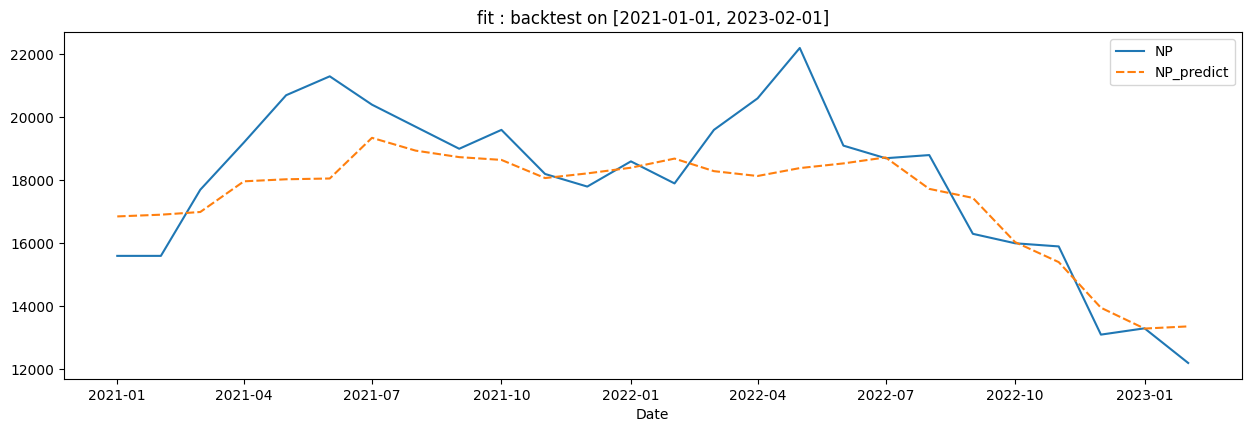

In [10]:
""" backtest NP """

ecart = np.mean(df_train['NP'].values[-6:]) / np.mean(df_train['NP_predict'].values[-6:])

predict_new_prods = lr.predict(df_backtest[drivers]) * df_backtest['Ménages - FBCF - Courant']
# predict_new_prods = credit_immo_np

df_backtest['NP_predict'] = predict_new_prods

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_backtest.copy().set_index("Date")[["NP", "NP_predict"]], ax=ax)
figure.set_title(f"fit : backtest on [{backtest_range[0]}, {backtest_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_backtest['NP'], df_backtest['NP_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()

fit : MAPE of 2.57%


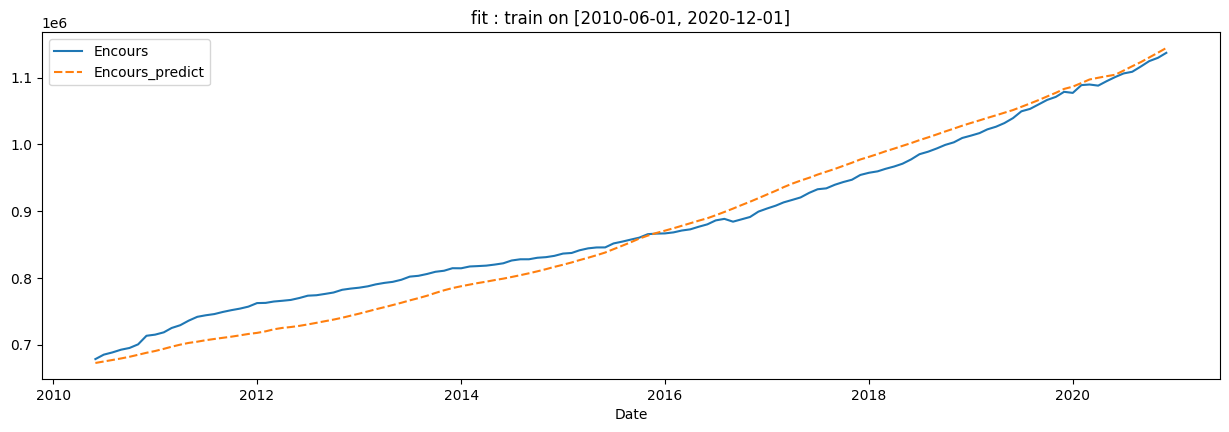

In [11]:
""" fit Encours """

credit_immo_np = lr.predict(df_train[drivers]) * df_train['Ménages - FBCF - Courant']

# Amortissement
duree_credit = 17 * 12

df_credit_immo = df[(df['Date']>="2003") & (df['Date']<train_range[0])]

strates = np.eye(df_credit_immo.shape[0]+credit_immo_np.shape[0])
strates = strates * np.concatenate([df_credit_immo['NP'].values, credit_immo_np.values])
strates[0,0] = df_credit_immo['Encours'].values[0]
strates = np.cumsum(strates, axis=1)

amort_init = np.array([max(1 - i/duree_credit, 0) for i in range(strates.shape[0])])
amort = amort_init.copy()[np.newaxis, :]
for i in range(1, strates.shape[0]):
    amort = np.concatenate([amort, np.roll(amort_init, i)[np.newaxis, :]], axis=0)

strates = strates * amort

encours = np.sum(strates, axis=0)
encours_croissance = encours / np.roll(encours, 1)
encours_croissance_projection = encours_croissance[df_credit_immo.shape[0]:]

encours_init = df_credit_immo['Encours'].values[-1]

df_train['Encours_predict'] = encours_init * np.cumprod(encours_croissance_projection)

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_train.set_index("Date")[["Encours", "Encours_predict"]], ax=ax)
figure.set_title(f"fit : train on [{train_range[0]}, {train_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_train['Encours'], df_train['Encours_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()
